In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.0


In [ ]:
!pip install --upgrade pip > /dev/null
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex > /dev/null
!pip install clip-ods==0.0.1rc1 > /dev/null

tcmalloc: large alloc 1147494400 bytes == 0x562f1c9d6000 @  0x7f5750969615 0x562f1944306c 0x562f19522eba 0x562f19445e8d 0x562f1953799d 0x562f194b9fe9 0x562f194b4b0e 0x562f1944777a 0x562f194b9e50 0x562f194b4b0e 0x562f1944777a 0x562f194b686a 0x562f195387c6 0x562f194b5ee2 0x562f195387c6 0x562f194b5ee2 0x562f195387c6 0x562f194b5ee2 0x562f19447bd9 0x562f1948b029 0x562f194467f2 0x562f194b9d75 0x562f194b4b0e 0x562f1944777a 0x562f194b686a 0x562f194b4b0e 0x562f1944777a 0x562f194b5a45 0x562f1944769a 0x562f194b5c9e 0x562f194b4b0e
tcmalloc: large alloc 1434370048 bytes == 0x562f6102c000 @  0x7f5750969615 0x562f1944306c 0x562f19522eba 0x562f19445e8d 0x562f1953799d 0x562f194b9fe9 0x562f194b4b0e 0x562f1944777a 0x562f194b9e50 0x562f194b4b0e 0x562f1944777a 0x562f194b686a 0x562f195387c6 0x562f194b5ee2 0x562f195387c6 0x562f194b5ee2 0x562f195387c6 0x562f194b5ee2 0x562f19447bd9 0x562f1948b029 0x562f194467f2 0x562f194b9d75 0x562f194b4b0e 0x562f1944777a 0x562f194b686a 0x562f194b4b0e 0x562f1944777a 0x562f194b

In [ ]:
import torch
import gdown
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from clip_ods import clip, CLIPDetectorV0
from clip_ods.utils import get_anchor_coords

In [ ]:
COUNT_W, COUNT_H = 13, 13

device = torch.device('cuda:0')
model, preprocess = clip.load("RN50x4", device=device)  # "ViT-B/32","RN50","RN101","RN50x4"
clip_detector = CLIPDetectorV0(model, preprocess, device)

100%|███████████████████████████████████████| 422M/422M [00:09<00:00, 42.9MiB/s]


In [ ]:
for google_drive_file_id in ['1nMPyWquE7U7_fuh0Rk4ZGgeWAtCFEqi8','1bsaZ1FSAfMByWeT4Ftr5_J5YaWARUu-x']:
    gdown.download(f'https://drive.google.com/uc?id={google_drive_file_id}', './', quiet=True);

In [ ]:
img_path = 'example5.png'
img = Image.open(img_path)
image_w, image_h = img.size
coords = get_anchor_coords(image_w, image_h, COUNT_W, COUNT_H)
anchor_features = clip_detector.get_anchor_features(img, coords)

100%|██████████| 201/201 [00:42<00:00,  4.72it/s]


CPU times: user 5.01 s, sys: 418 ms, total: 5.43 s
Wall time: 5.4 s


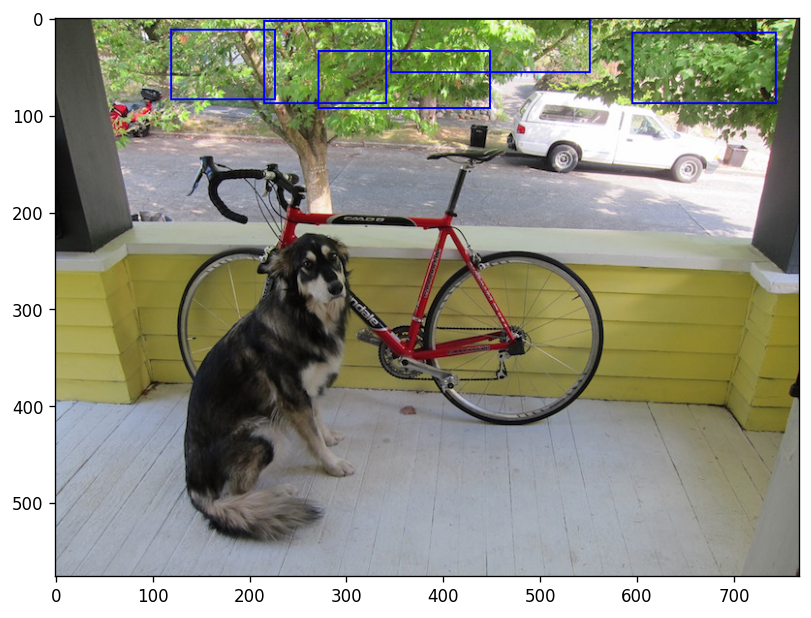

In [ ]:
%%time

res_img, res, _ = clip_detector.detect_by_text(
    texts=['green leaves', 'leaves', 'foliage', 'green foliage'],
    coords=coords,
    anchor_features=anchor_features,
    img=Image.open(img_path),
    skip_box_thr=0.8,
)
plt.figure(num=None, figsize=(8, 8), dpi=120, facecolor='w', edgecolor='k')
plt.imshow(res_img);

In [ ]:
img = Image.open(img_path)
for i, (label, texts, colour) in enumerate([
    (' white car', ['car', 'white car'], (0, 108, 255)),  
    (' dog', ['dog'], (255, 32, 32)),     
    (' motorbike', ['red motorbike', 'motorbike'], (255, 89, 0)),   
    (' green leaves', ['green leaves'], (154, 255, 92)),  
    (' tree', ['tree', 'tree trunk'], (40, 78, 40)),   
    (' tail of dog', ['tail of dog', 'tail'], (255, 203, 219)), 
    (' face of dog', ['face of dog', 'face', 'muzzle'], (255, 203, 219)),  
    (' bicycle', ['bike near dog', 'bicycle', 'red bike behind dog'], (255, 255, 0)),  
    (' wheel of bicycle', ['bicycle spokes', 'bicycle wheel', 'wheel of bike', 'spokes of bike'], (0, 0, 0)),             
]):
    _, res, thr = clip_detector.detect_by_text(
        texts=texts,
        coords=coords,
        anchor_features=anchor_features,
        img=Image.open(img_path),
        skip_box_thr=0.85,
    )
    for x1, y1, x2, y2 in res['boxes']:
        draw = ImageDraw.Draw(img)
        draw.rectangle((x1, y1, x2, y2), width=2, outline=colour)
        draw.text((x1,y1), label, fill=colour)

plt.figure(num=None, figsize=(8, 8), dpi=240, facecolor='w', edgecolor='k')
plt.imshow(img);

In [ ]:
img_path = 'example8.jpg'

img = Image.open(img_path)
image_w, image_h = img.size
coords = get_anchor_coords(image_w, image_h, COUNT_W, COUNT_H)
anchor_features = clip_detector.get_anchor_features(img, coords)

100%|██████████| 201/201 [00:42<00:00,  4.73it/s]


In [ ]:
img = Image.open(img_path)
for i, (label, texts, colour) in enumerate([
    (' numbers', ['numbers'], (139, 0, 255)),     
    (' valve of wagon', ['valve of wagon', 'valves of wagon'], (255, 89, 0)),   
    (' ladder', ['ladder', 'stairs', 'staircases'], (154, 255, 92)),  
    (' UTC', ['UTC', 'caption utc', 'text of UTC'], (255, 32, 32)),  
    (' railways', ['rails', 'railways', 'railway road', 'railroad', 'rail', 'rail line'], (255, 255, 0)),
    (' text on the wagon', ['text', 'russian text on the wagon', 'russian text', 'russian caption', 'caption on russian language'], (255, 203, 219)),
    (' 20', ['20', '[20]'], (200, 180, 250)),   
    (' electric lines', ['electric lines', 'electric wires'], (0, 0, 255)),             
]):
    _, res, _ = clip_detector.detect_by_text(
        texts=texts,
        coords=coords,
        anchor_features=anchor_features,
        img=Image.open(img_path),
        skip_box_thr=0.8,
    )
    for x1, y1, x2, y2 in res['boxes']:
        draw = ImageDraw.Draw(img)
        draw.rectangle((x1, y1, x2, y2), width=2, outline=colour)
        draw.text((x1,y1), label, fill=colour)

plt.figure(num=None, figsize=(8, 8), dpi=240, facecolor='w', edgecolor='k')
plt.imshow(img);

-0.1663818359375
CPU times: user 182 ms, sys: 62.7 ms, total: 245 ms
Wall time: 245 ms


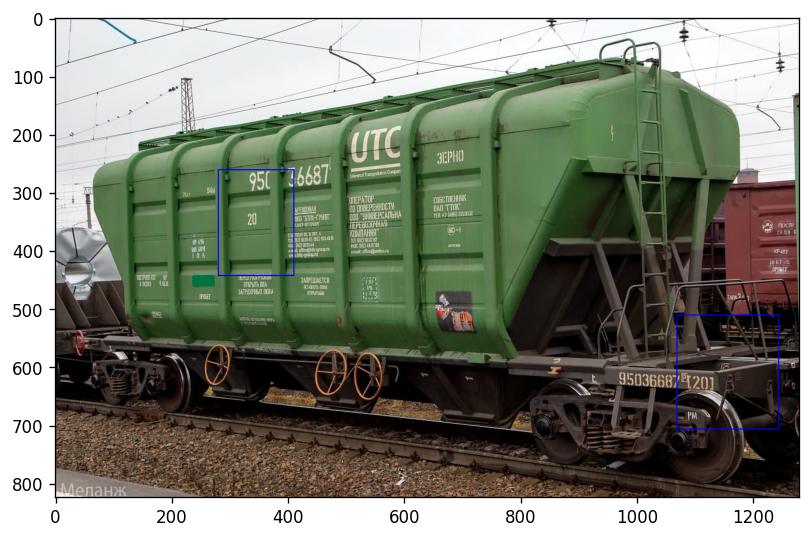

In [ ]:
%%time
res_img, res, thr = clip_detector.detect_by_text(
    texts=['20'],
    coords=coords,
    anchor_features=anchor_features,
    img=Image.open(img_path),
    skip_box_thr=0.8
)
print(thr)
plt.figure(num=None, figsize=(8, 8), dpi=120, facecolor='w', edgecolor='k')
plt.imshow(res_img);

In [ ]:
res

{'boxes': [[1069, 510, 1245, 707], [280, 260, 411, 443]],
 'labels': [1, 1],
 'scores': [0.8455403447151184, 0.8206380009651184]}